In [1]:
import json
import os
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset

F:\anaconda3\envs\p39_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_seq_len=768):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.data = self.load_data(file_path)

    def load_data(self, file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        prompt = entry["prompt"]
        completion = entry["completion"]

        # Combine prompt and completion into a single input sequence
        input_text = f"{prompt} {self.tokenizer.sep_token} {completion}"

        # Tokenize and truncate input sequence
        input_ids = self.tokenizer.encode(input_text, max_length=self.max_seq_len, truncation=True)

        return torch.tensor(input_ids)

In [4]:
def prepare_dataset(dataset_name, file_path, tokenizer):
    # Check if the dataset file already exists
    if not os.path.exists(file_path):
        # Load the dataset from Hugging Face datasets library
        dataset = load_dataset(dataset_name)

        # Save the dataset to a file for future use
        with open(file_path, 'w') as file:
            json.dump(dataset, file)
    else:
        # Load the dataset from the file
        with open(file_path, 'r') as file:
            dataset = json.load(file)

    # Create a CustomDataset from the loaded dataset
    custom_dataset = CustomDataset(file_path, tokenizer)

    # Split the dataset into training, validation, and test sets
    num_samples = len(custom_dataset)
    train_split = int(0.8 * num_samples)
    val_split = int(0.1 * num_samples)
    
    train_dataset = Subset(custom_dataset, list(range(train_split)))
    val_dataset = Subset(custom_dataset, list(range(train_split, train_split + val_split)))
    test_dataset = Subset(custom_dataset, list(range(train_split + val_split, num_samples)))

    return train_dataset, val_dataset, test_dataset

In [5]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [23]:
def train(
    train_dataset, val_dataset, model, tokenizer,
    batch_size=16, epochs=5, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="wreckgar",
    save_model_on_epoch=False,
):
    device = torch.device("cuda")
    model = model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    best_val_loss = float('inf')

    train_losses, val_losses = [], []

    # Training loop
    for epoch in range(epochs):
        print(f"Training epoch {epoch}")

        # pdb.set_trace()

        # Training step
        for idx, entry in tqdm(enumerate(train_dataloader)):
            input_tensor, carry_on, remainder = pack_tensor(entry, None, max_seq_len)

            # if carry_on and idx != len(train_dataloader) - 1:
            #     continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (idx + 1) % batch_size == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

        # Validation loss
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for val_entry in tqdm(val_dataloader):
                val_input_tensor = val_entry.to(device)
                val_outputs = model(val_input_tensor, labels=val_input_tensor)
                val_loss += val_outputs[0].item()
        val_loss /= len(val_dataloader)
        print(f"Validation Loss: {val_loss}")
        val_losses.append(val_loss)

        # Training loss
        train_loss = 0
        with torch.no_grad():
            for train_entry in tqdm(train_dataloader):
                train_input_tensor = train_entry.to(device)
                train_outputs = model(train_input_tensor, labels=train_input_tensor)
                train_loss += train_outputs[0].item()
        train_loss /= len(train_dataloader)
        print(f"Training Loss: {train_loss}")
        train_losses.append(train_loss)

        # Save the model if it's the best so far
        if save_model_on_epoch and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-best.pt"),
            )

    return model, val_losses, train_losses

In [7]:
def evaluate(model, dataloader, device, output_file, tokenizer):
    model.eval()
    total_loss = 0
    detokenized_outputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_tensor = batch.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            total_loss += outputs.loss.item()
            
            # Detach the logits before using them for decoding
            # logits = outputs.logits.detach()
            # detokenized_output = tokenizer.decode(torch.argmax(logits, dim=-1).tolist(), skip_special_tokens=True)
            # detokenized_outputs.append(detokenized_output)
            # output_file.write(detokenized_output + '\n')

    avg_loss = total_loss / len(dataloader)
    return avg_loss, detokenized_outputs

In [8]:
def collate_fn(batch):
    return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)

### Fixing evaluate()

In [9]:
# Define your GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Specify the dataset name and file path
dataset_name = "propmts_and_completions"
file_path = 'prompts_v3.json'
output_file = 'detokenized_outputs.txt'

# Prepare the dataset
train_dataset, val_dataset, test_dataset = prepare_dataset(dataset_name, file_path, tokenizer)

In [15]:
# # Evaluate on the validation set
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
# val_loss, detokenized_outputs = evaluate(model, val_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
# print(f"Validation Loss: {val_loss}")

# # Evaluate on the test set
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
# test_loss, detokenized_outputs_test = evaluate(model, test_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_test.txt', tokenizer=tokenizer)
# print(f"Test Loss: {test_loss}")

### Fine-tuning

In [16]:
seed = 182
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [28]:
# Define your GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Specify the dataset name and file path
dataset_name = "propmts_and_completions"
file_path = 'prompts_v3.json'
output_file = 'detokenized_outputs.txt'

# Prepare the dataset
train_dataset, val_dataset, test_dataset = prepare_dataset(dataset_name, file_path, tokenizer)

# Train the model
trained_model, val_losses, train_losses = train(
    train_dataset, val_dataset, model, tokenizer, batch_size=8, epochs=50, lr=5e-3)

# Evaluate on the validation set
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
val_loss, detokenized_outputs = evaluate(trained_model, val_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
print(f"Validation Loss: {val_loss}")

# Evaluate on the test set
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loss, detokenized_outputs_test = evaluate(trained_model, test_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_test.txt', tokenizer=tokenizer)
print(f"Test Loss: {test_loss}")

Training epoch 0


11it [00:34,  3.15s/it]
100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Validation Loss: 2.962575078010559


100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Training Loss: 2.5153859745372427
Training epoch 1


11it [00:37,  3.45s/it]
100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Validation Loss: 2.8575074672698975


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


Training Loss: 2.5030937628312544
Training epoch 2


11it [00:36,  3.36s/it]
100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Validation Loss: 2.7303751707077026


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Training Loss: 2.3322500749067827
Training epoch 3


11it [00:37,  3.42s/it]
100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Validation Loss: 2.601155638694763


100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


Training Loss: 2.186307733709162
Training epoch 4


11it [00:35,  3.22s/it]
100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation Loss: 2.5165114402770996


100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Training Loss: 2.091016498478976
Training epoch 5


11it [00:39,  3.60s/it]
100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Validation Loss: 2.4562076330184937


100%|██████████| 11/11 [00:10<00:00,  1.00it/s]


Training Loss: 1.936381762677973
Training epoch 6


11it [00:37,  3.45s/it]
100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation Loss: 2.404120087623596


100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Training Loss: 1.8787626028060913
Training epoch 7


11it [00:37,  3.41s/it]
100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation Loss: 2.3307586908340454


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Training Loss: 1.7910621924833818
Training epoch 8


11it [00:37,  3.36s/it]
100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Validation Loss: 2.2944629192352295


100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


Training Loss: 1.6435438502918591
Training epoch 9


11it [00:37,  3.38s/it]
100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Validation Loss: 2.2848050594329834


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Training Loss: 1.5480836738239636
Training epoch 10


11it [00:36,  3.33s/it]
100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation Loss: 2.2839272022247314


100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Training Loss: 1.3996164798736572
Training epoch 11


11it [00:37,  3.41s/it]
100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Validation Loss: 2.3020533323287964


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


Training Loss: 1.2697342742573132
Training epoch 12


11it [00:37,  3.38s/it]
100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Validation Loss: 2.3345067501068115


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Training Loss: 1.2067482688210227
Training epoch 13


11it [00:36,  3.30s/it]
100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Validation Loss: 2.38863468170166


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


Training Loss: 1.0461737459356135
Training epoch 14


11it [00:34,  3.16s/it]
100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Validation Loss: 2.4459608793258667


100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Training Loss: 0.9221034266731956
Training epoch 15


11it [00:35,  3.27s/it]
100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Validation Loss: 2.546790361404419


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Training Loss: 0.7425556562163613
Training epoch 16


11it [00:37,  3.42s/it]
100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Validation Loss: 2.6530978679656982


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


Training Loss: 0.6595106449994174
Training epoch 17


11it [00:38,  3.53s/it]
100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Validation Loss: 2.760121703147888


100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


Training Loss: 0.5267907353964719
Training epoch 18


11it [00:38,  3.49s/it]
100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Validation Loss: 2.958250641822815


100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Training Loss: 0.4151690791953694
Training epoch 19


11it [00:36,  3.29s/it]
100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Validation Loss: 3.1042526960372925


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Training Loss: 0.31087905168533325
Training epoch 20


11it [00:38,  3.46s/it]
100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Validation Loss: 3.178301453590393


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Training Loss: 0.23048721931197427
Training epoch 21


11it [00:36,  3.36s/it]
100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Validation Loss: 3.2895196676254272


100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Training Loss: 0.16649555482647635
Training epoch 22


11it [00:35,  3.24s/it]
100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Validation Loss: 3.3764947652816772


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Training Loss: 0.11636784198609265
Training epoch 23


11it [00:38,  3.47s/it]
100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Validation Loss: 3.4969747066497803


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


Training Loss: 0.08277152207764712
Training epoch 24


11it [00:36,  3.36s/it]
100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Validation Loss: 3.6144256591796875


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


Training Loss: 0.06420360844243657
Training epoch 25


11it [00:36,  3.33s/it]
100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Validation Loss: 3.694543719291687


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Training Loss: 0.04694212194193493
Training epoch 26


11it [00:37,  3.40s/it]
100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Validation Loss: 3.762031078338623


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Training Loss: 0.03878226046535102
Training epoch 27


11it [00:37,  3.41s/it]
100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Validation Loss: 3.8257827758789062


100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Training Loss: 0.031571375714106995
Training epoch 28


11it [00:36,  3.33s/it]
100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Validation Loss: 3.855168342590332


100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Training Loss: 0.026840649206529964
Training epoch 29


11it [00:38,  3.46s/it]
100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation Loss: 3.888831853866577


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


Training Loss: 0.0235386107286269
Training epoch 30


11it [00:37,  3.42s/it]
100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Validation Loss: 3.9286811351776123


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Training Loss: 0.02265583723783493
Training epoch 31


11it [00:38,  3.48s/it]
100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Validation Loss: 3.9772703647613525


100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Training Loss: 0.019323338923806496
Training epoch 32


11it [00:37,  3.39s/it]
100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Validation Loss: 4.032804846763611


100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Training Loss: 0.02083979487757791
Training epoch 33


11it [00:38,  3.48s/it]
100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Validation Loss: 4.087648391723633


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Training Loss: 0.0166526170108806
Training epoch 34


11it [00:37,  3.39s/it]
100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Validation Loss: 4.1312713623046875


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Training Loss: 0.015566881830719385
Training epoch 35


11it [00:37,  3.42s/it]
100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Validation Loss: 4.170990943908691


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Training Loss: 0.015170523981479082
Training epoch 36


11it [00:36,  3.30s/it]
100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Validation Loss: 4.205463409423828


100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Training Loss: 0.014724535528909077
Training epoch 37


11it [00:37,  3.44s/it]
100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Validation Loss: 4.235278367996216


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Training Loss: 0.013938609764657238
Training epoch 38


11it [00:35,  3.22s/it]
100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation Loss: 4.266150951385498


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Training Loss: 0.015129081904888153
Training epoch 39


11it [00:36,  3.34s/it]
100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Validation Loss: 4.298298358917236


100%|██████████| 11/11 [00:07<00:00,  1.38it/s]


Training Loss: 0.01312054879963398
Training epoch 40


11it [00:36,  3.33s/it]
100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Validation Loss: 4.3302271366119385


100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Training Loss: 0.013813167895105753
Training epoch 41


11it [00:35,  3.24s/it]
100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Validation Loss: 4.364382982254028


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Training Loss: 0.012057589578696272
Training epoch 42


11it [00:37,  3.45s/it]
100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Validation Loss: 4.401311874389648


100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


Training Loss: 0.013221680356020277
Training epoch 43


11it [00:38,  3.49s/it]
100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Validation Loss: 4.438671112060547


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Training Loss: 0.012488179205154831
Training epoch 44


11it [00:37,  3.40s/it]
100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Validation Loss: 4.476414918899536


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Training Loss: 0.010915151141075925
Training epoch 45


11it [00:35,  3.21s/it]
100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Validation Loss: 4.509992599487305


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Training Loss: 0.012009239840236578
Training epoch 46


11it [00:36,  3.32s/it]
100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation Loss: 4.5444114208221436


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Training Loss: 0.011266194961287758
Training epoch 47


11it [00:36,  3.35s/it]
100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Validation Loss: 4.574197053909302


100%|██████████| 11/11 [00:09<00:00,  1.22it/s]


Training Loss: 0.011291096621954983
Training epoch 48


11it [00:38,  3.48s/it]
100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Validation Loss: 4.6017985343933105


100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


Training Loss: 0.01059002513912591
Training epoch 49


11it [00:37,  3.42s/it]
100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Validation Loss: 4.625795364379883


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Training Loss: 0.010931436946107582


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s]


Validation Loss: 4.937857151031494


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

Test Loss: 4.780426718971946


### Loss curves

In [19]:
import matplotlib.pyplot as plt

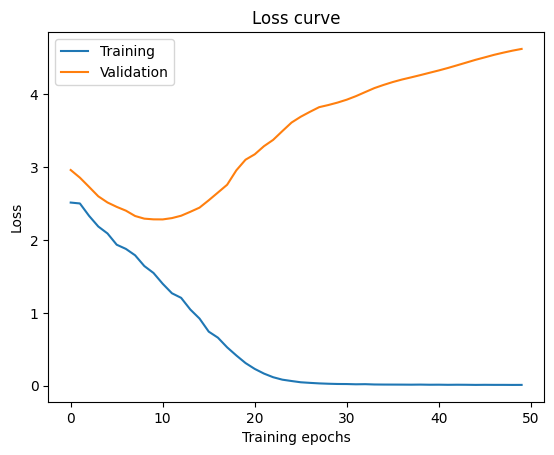

In [40]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.set_title("Loss curve")
ax.set_xlabel("Training epochs")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

In [ ]:
# n_epochs = 10

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# train_losses, valid_losses = [], []

# for e in range(epochs):
#     model = train(train_dataset, valid_dataset, model, tokenizer)
    
#     train_loss, detokenized_outputs_train = \
#     evaluate(model, train_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_train.txt', tokenizer=tokenizer)
#     train_losses.append(train_loss)
    
#     valid_loss, detokenized_outputs_valid = \
#     evaluate(model, valid_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
#     valid_losses.append(valid_loss)